In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cpu device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


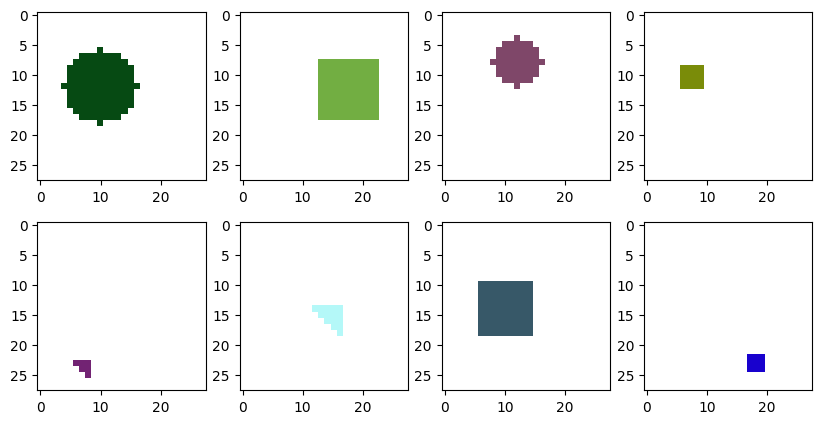

In [14]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=60000, image_size=(28, 28), random_color=True):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


class GeometricFiguresDatasetBlackWhite(GeometricFiguresDataset):
    def __init__(self, num_samples=60000, image_size=(28, 28)):
        super().__init__(num_samples, image_size, random_color=False)

    def choose_color(self):
        return np.array([0, 0, 0])  # Black color

    def __getitem__(self, idx):
        img, label =  super().__getitem__(idx)
        img = img[0]  # Take only one channel
        img = img/255.0  # Normalize
        return img, label




dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


# Convolutional autoencoder

get a sence of how complex our model should be

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
            super(Encoder, self).__init__()
            self.latent_dim = latent_dim

            encoder_channels = [input_channels] + encoder_channels
            self.encoder_channels = encoder_channels

            self.conv_layers = nn.ModuleList()
            for i in range(len(encoder_channels)-1):
                self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
                self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
                self.conv_layers.append(nn.ReLU())

            self.flatten = nn.Flatten()
            self.fc = nn.Linear(10000, self.latent_dim) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x

class Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]

        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.fc2 = nn.Linear(28*28*3, 3*28*28) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())



    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)

        x = x.flatten(1)

        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        x = x.view(-1, 3, 28, 28)
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        latent_dim = latent_dim
        output_conv_shape = torch.Size([encoder_channels[-1], 25, 25])
        encoder_channels = [input_channels] + encoder_channels
        self.decoder = Decoder(encoder_channels, latent_dim, output_conv_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True, num_samples=20000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


torch.Size([128, 3, 28, 28])


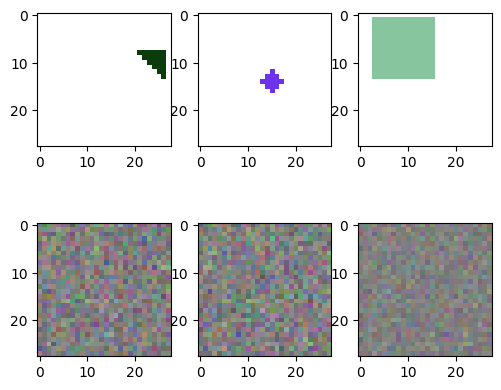

In [17]:

# Define model parameters
input_channels = 3
encoder_channels = [4, 8, 16]    #shpuld be like 8,16,32 ...
latent_dim = 20

model_autoencoder = ConvAutoencoder(input_channels, encoder_channels, latent_dim)
#criterion = nn.MSELoss()
criterion = nn.BCELoss()

model_autoencoder = model_autoencoder.to(device)
criterion = criterion.to(device)


random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_autoencoder(random_batch)

print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [18]:
# Training loop
optimizer = optim.Adam(model_autoencoder.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model_autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}")


Epoch [1/5], Loss: 0.08867
Epoch [2/5], Loss: 0.05252
Epoch [3/5], Loss: 0.04768
Epoch [4/5], Loss: 0.04457
Epoch [5/5], Loss: 0.04279


torch.Size([128, 3, 28, 28]) torch.Size([128, 3, 28, 28])


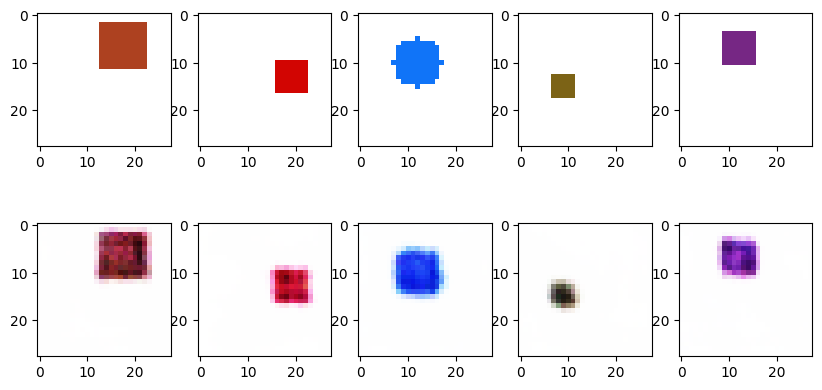

In [19]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_autoencoder(random_batch)
print(output.shape, random_batch.shape)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


looks good enough for ~5 min training time on Colab T4

# Variational autoencoder variant

In [20]:
class VAE_Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
        super(VAE_Encoder, self).__init__()
        self.latent_dim = latent_dim

        encoder_channels = [input_channels] + encoder_channels
        self.encoder_channels = encoder_channels

        self.conv_layers = nn.ModuleList()
        for i in range(len(encoder_channels)-1):
            self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
            self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
            self.conv_layers.append(nn.ReLU())

        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(10000, latent_dim)
        self.fc_logvar = nn.Linear(10000, latent_dim)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


class VAE_Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(VAE_Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]

        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.fc2 = nn.Linear(28*28*3, 3*28*28) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())



    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)

        x = x.flatten(1)

        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        x = x.view(-1, 3, 28, 28)
        return x



class VAE(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        latent_dim = latent_dim
        output_conv_shape = torch.Size([encoder_channels[-1], 25, 25])
        encoder_channels = [input_channels] + encoder_channels
        self.decoder = VAE_Decoder(encoder_channels, latent_dim, output_conv_shape)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) # e^[0.5*logvar] = sqrt(e^logvar) = sqrt(var)
        eps = torch.randn_like(std) #torch.randn_like(std) returns a tensor with the same size as std with values sampled from N(0,1)
        z = mu + eps*std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar #return mu, logvar for KL divergence calculation, and X for reconstruction loss



In [21]:
def loss_function(criterion, recon_x, x, mu, logvar, KL_weight = 1.0):
    MSE = criterion(recon_x, x) #used to define nn.MSELoss() right here in the function, which is probably not the best idea
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    SUM = MSE + KL_weight*KLD
    return SUM


In [22]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True, num_samples=20000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


torch.Size([128, 3, 28, 28])


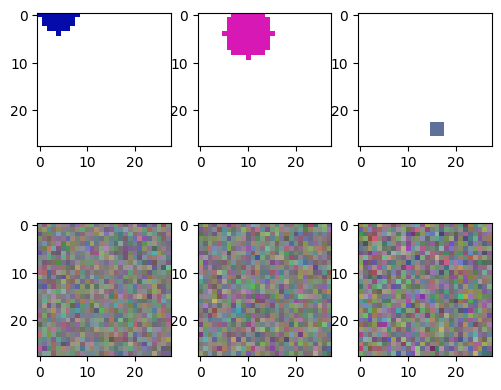

In [23]:
input_channels = 3  # RGB channels
encoder_channels = [4, 8, 16]    #shpuld be like 8,16,32 ...
latent_dim = 20


model_vae = VAE(input_channels, encoder_channels, latent_dim)
#criterion = nn.MSELoss()
criterion = nn.BCELoss()

model_vae = model_vae.to(device)


random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output_all = model_vae(random_batch)
output = output_all[0]


print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [24]:
optimizer = optim.Adam(model_vae.parameters(), lr=5e-4)


In [25]:
num_epochs = 5
KL_weight = 1

#after 100 epochs we achieved 0.00001 for KL 0.00703 for rec,
#then 50 epochs with KL weight = 0
#then 50 epochs with KL weight = 1e-3 -> Loss: 0.00699, KL: 0.00002, Recon: 0.00699

for epoch in range(num_epochs):
    running_loss = 0.0
    running_KL = 0.0
    running_recon = 0.0

    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model_vae(images)
        recon_x = outputs[0]
        mu = outputs[1]
        logvar = outputs[2]
        loss = loss_function(criterion = criterion, recon_x=recon_x, x = images, mu = mu, logvar = logvar, KL_weight = KL_weight)
        loss.backward()
        optimizer.step()

        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        recon = loss - KL*KL_weight

        running_KL += KL.item() * images.size(0)
        running_recon += recon.item() * images.size(0)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_KL = running_KL / len(dataloader.dataset)
    epoch_recon = running_recon / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, KL: {epoch_KL:.5f}, Recon: {epoch_recon:.5f}")



Epoch [1/5], Loss: 51.19338, KL: 51.03858, Recon: 0.15480
Epoch [2/5], Loss: 3.96800, KL: 3.82731, Recon: 0.14069
Epoch [3/5], Loss: 2.26641, KL: 2.12733, Recon: 0.13907
Epoch [4/5], Loss: 1.78996, KL: 1.65141, Recon: 0.13855
Epoch [5/5], Loss: 1.48780, KL: 1.34946, Recon: 0.13833


loss_vae=3.09018 ; loss_autoencoder=0.04121


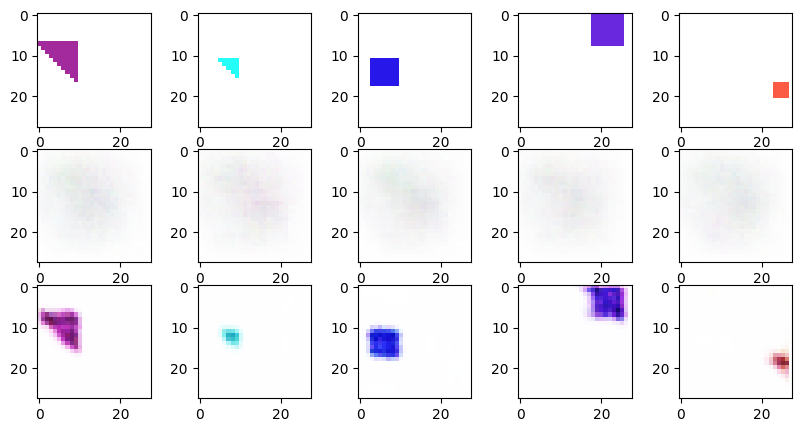

In [26]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model_vae(random_batch)[0]
output_autoencoder = model_autoencoder(random_batch)

loss_vae = criterion(random_batch, output)
loss_autoencoder = criterion(output_autoencoder, random_batch)

print(f'{loss_vae=:.5f} ; {loss_autoencoder=:.5f}')

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(3, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(3, 5, i+11)
    plt.imshow(output_autoencoder[i].permute(1, 2, 0).cpu().detach().numpy())
